# AI 201 Programming Assignment 3
## Multilayer Perceptron from Scratch

Submitted by: 
Jan Lendl R. Uy, 2019-00312

In [1]:
!pip install numpy imbalanced-learn matplotlib tqdm ipywidgets

In [2]:
import csv
import random
import numpy as np
import time
import os
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from tqdm.notebook import tqdm
from collections import Counter

In [3]:
## Notebook constants
NETWORK_A_WEIGHTS = "trained_weights_network_a.csv"
NETWORK_B_WEIGHTS = "trained_weights_network_b.csv"

NETWORK_A_PREDICTIONS = "predictions_for_test_tanh.csv"
NETWORK_B_PREDICTIONS = "predictions_for_test_leakyrelu.csv"

## Load the dataset
- $X$: Features from `data.csv`
- $y$: Labels from `data_labels.csv`

In [4]:
def read_features_file(file_path, dtype=float):
    data = []
    try:
        with open(file_path, 'r', newline='') as file:
            reader = csv.reader(file)
            # Read and convert data
            for row in reader:
                try:
                    converted_row = [dtype(val) for val in row]
                    data.append(converted_row)
                except ValueError as e:
                    raise ValueError(f"Error converting value in row: {row}. {str(e)}")
    except FileNotFoundError:
        raise FileNotFoundError(f"Could not find file: {file_path}")
    except Exception as e:
        raise Exception(f"Error reading CSV file {file_path}: {str(e)}")
    
    return np.array(data)

def read_labels_file(file_path, dtype=int):
    data = []
    try:
        with open(file_path, 'r', newline='') as file:
            reader = csv.reader(file)
            # Read and convert data
            for row in reader:
                try:
                    value = dtype(row[0])  # Get only first element since there is only 1
                    data.append(value)
                except ValueError as e:
                    raise ValueError(f"Error converting value in row: {row}. {str(e)}")
    except FileNotFoundError:
        raise FileNotFoundError(f"Could not find file: {file_path}")
    except Exception as e:
        raise Exception(f"Error reading CSV file {file_path}: {str(e)}")
    
    return np.array(data)

In [5]:
X = read_features_file("data.csv")
X_test = read_features_file("test_set.csv")
y_raw = read_labels_file("data_labels.csv")

In [6]:
def one_hot_encode(labels, num_classes=8):
    # Convert labels to 0-based indexing (subtract 1 since labels start from 1)
    zero_based_labels = labels.reshape(-1) - 1
    
    # Create a zero matrix of shape (n_samples, num_classes)
    n_samples = len(labels)
    one_hot = np.zeros((n_samples, num_classes))
    
    # Set the appropriate indices to 1
    one_hot[np.arange(n_samples), zero_based_labels] = 1
    
    return one_hot

In [7]:
y = one_hot_encode((y_raw))

## Observe the dataset with apparent imbalance

In [8]:
def show_class_distribution(y_one_hot):
    # Convert one-hot to class indices (adding 1 since classes are 1-8)
    y_classes = np.argmax(y_one_hot, axis=1) + 1
    
    # Get class frequencies
    class_counts = Counter(y_classes)
    
    # Sort by class labels
    sorted_counts = dict(sorted(class_counts.items()))
    
    # Calculate percentages
    total_samples = len(y)
    percentages = {k: (v/total_samples) for k, v in sorted_counts.items()}
    
    # Print frequency table
    print("\nClass Distribution:")
    print("-" * 50)
    print(f"{'Class':<10} {'Count':<10} {'Percentage':>10}")
    print("-" * 50)
    for class_label, count in sorted_counts.items():
        percentage = percentages[class_label]
        print(f"{class_label:<10} {count:<10} {percentage:>10.2f}%")
    print("-" * 50)
    print(f"Total: {total_samples}")

In [9]:
show_class_distribution(np.array(y))


Class Distribution:
--------------------------------------------------
Class      Count      Percentage
--------------------------------------------------
1          1625             0.47%
2          233              0.07%
3          30               0.01%
4          483              0.14%
5          287              0.08%
6          310              0.09%
7          52               0.01%
8          466              0.13%
--------------------------------------------------
Total: 3486


## Balance the dataset by oversampling using SMOTE

In [10]:
smote = SMOTE()
steps = [("o", smote)]
pipeline = Pipeline(steps=steps)
X, y = pipeline.fit_resample(X, y)

In [11]:
show_class_distribution(y)


Class Distribution:
--------------------------------------------------
Class      Count      Percentage
--------------------------------------------------
1          1625             0.12%
2          1625             0.12%
3          1625             0.12%
4          1625             0.12%
5          1625             0.12%
6          1625             0.12%
7          1625             0.12%
8          1625             0.12%
--------------------------------------------------
Total: 13000


## Split the balanced dataset into training and test sets

In [12]:
def train_test_split(X, y, test_size=0.3, random_state=None):
    if random_state is not None:
        random.seed(random_state)
    
    # Create list of indices and shuffle it
    indices = list(range(len(X)))
    random.shuffle(indices)
    
    # Calculate split point
    split = int(len(X) * (1 - test_size))
    
    # Split the data
    train_indices = indices[:split]
    test_indices = indices[split:]
    
    X_train = np.array([X[i] for i in train_indices])
    X_test = np.array([X[i] for i in test_indices])
    y_train = np.array([y[i] for i in train_indices])
    y_test = np.array([y[i] for i in test_indices])
    
    return X_train, X_test, y_train, y_test

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=800/len(X), random_state=0)

In [14]:
print(f"Size of X_train: {X_train.shape}")
print(f"Size of X_val: {X_val.shape}")
print(f"Size of y_train: {y_train.shape}")
print(f"Size of y_val: {y_val.shape}")

Size of X_train: (12200, 354)
Size of X_val: (800, 354)
Size of y_train: (12200, 8)
Size of y_val: (800, 8)


## Define the blocks of the Multilayer Perceptron

In [15]:
class Linear:
    
    def __init__(self, input_size, neurons, random_state=0):
        self.input = None
        self.output = None
        self.weight_gradients = None
        self.prev_weight_gradients = np.zeros((input_size + 1, neurons))
        
        np.random.seed(random_state)
        
        # Initialize weights with He initialization
        scale = np.sqrt(2.0 / input_size)  # Don't include bias in scale calculation
        self.weights = np.random.normal(0, scale, (input_size + 1, neurons))
        
        # Initialize bias weights (last row) to zeros
        self.weights[-1, :] = 0.0
    
    def forward(self, X):
        bias = np.ones((X.shape[0], 1))
        self.input = np.hstack((X, bias))
        self.output = self.input @ self.weights
        return self.output
    
    def backward(self, delta):
        # Calculate gradients for all weights including bias
        self.weight_gradients = self.input.T @ delta
        return delta

### Activation Functions

In [16]:
class Logistic():
    """Logistic (sigmoid) activation function: sigma(x) = 1/(1 + exp(-ax))"""
    
    def __init__(self, a=1.0):
        self.a = a
        self.output = None
        self.input = None
        
    def forward(self, x):
        self.input = x
        self.output = 1 / (1 + np.exp(-self.a * self.input))
        return self.output
    
    def backward(self):
        # derivative = a * σ(ax)(1 - σ(ax))
        derivative = self.a * self.output * (1 - self.output)
        return derivative

class Tanh():
    """Hyperbolic tangent activation function: sigma(x) = a*tanh(bx)"""
    
    def __init__(self, a=1.0, b=1.0):
        self.a = a
        self.b = b
        self.output = None
        self.input = None
        
    def forward(self, x):
        """Forward pass of tanh function"""
        self.input = x
        self.output = self.a * np.tanh(self.b * x)
        return self.output
    
    def backward(self):
        """Backward pass of tanh function"""
        # derivative = a * b * (1 - tanh²(bx))
        derivative = self.b / self.a * (self.a - self.output) * (self.a + self.output)
        return derivative

class LeakyReLU():
    """Leaky ReLU activation function: sigma(x) = max(ax, x)"""
    
    def __init__(self, a=0.01):
        self.a = a
        self.output = None
        self.input = None
        
    def forward(self, x):
        """Forward pass of Leaky ReLU"""
        self.input = x
        self.output = np.where(x > 0, x, self.a * x)
        return self.output
    
    def backward(self):
        """Backward pass of Leaky ReLU"""
        derivative = np.where(self.input > 0, 1, self.a)
        return derivative

## Metrics

In [17]:
def convert_to_labels(one_hot):
    """Convert one-hot encoded vectors to class labels (1-8)"""
    return np.argmax(one_hot, axis=1) + 1

In [18]:
def accuracy_score(y_true, y_pred):
    """Compute accuracy score given ground truth y_true and predictions y_pred"""
    # Convert one-hot to class labels
    true_labels = convert_to_labels(y_true)
    pred_labels = convert_to_labels(y_pred)
    
    # Calculate accuracy
    return np.mean(true_labels == pred_labels)

def precision_recall_f1(y_true, y_pred):
    """Compute precision, recall, and F1-score given ground truth y_true and predictions y_pred"""
    # Convert to label format
    true_labels = convert_to_labels(y_true)
    pred_labels = convert_to_labels(y_pred)
    
    # Initialize dictionaries to store metrics for each class
    precision_dict = {}
    recall_dict = {}
    f1_dict = {}
    
    # Calculate metrics for each class
    unique_classes = np.unique(true_labels)
    
    for class_label in unique_classes:
        # True positives
        tp = np.sum((true_labels == class_label) & (pred_labels == class_label))
        
        # False positives
        fp = np.sum((true_labels != class_label) & (pred_labels == class_label))
        
        # False negatives
        fn = np.sum((true_labels == class_label) & (pred_labels != class_label))
        
        # Calculate precision
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        precision_dict[class_label] = precision
        
        # Calculate recall
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        recall_dict[class_label] = recall
        
        # Calculate F1 score
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        f1_dict[class_label] = f1
    
    return precision_dict, recall_dict, f1_dict

def matthews_correlation_coefficient(y_true, y_pred):
    """Compute Matthew's Correlation Coefficient given ground truth y_true and predictions y_pred"""
    # Convert to label format
    true_labels = convert_to_labels(y_true)
    pred_labels = convert_to_labels(y_pred)
    
    # Get number of classes
    n_classes = y_true.shape[1]
    
    # Create confusion matrix
    confusion_matrix = np.zeros((n_classes, n_classes))
    for i in range(len(true_labels)):
        confusion_matrix[true_labels[i]-1, pred_labels[i]-1] += 1
    
    # Calculate MCC
    t_sum = np.sum(confusion_matrix)
    s = np.sum(confusion_matrix.sum(axis=1) * confusion_matrix.sum(axis=0))
    ps = np.sum(np.diag(confusion_matrix))
    
    n = t_sum * t_sum
    
    # Calculate sum of squared predictions and true values
    sum_pred = np.sum(confusion_matrix.sum(axis=0) ** 2)
    sum_true = np.sum(confusion_matrix.sum(axis=1) ** 2)
    
    if n == sum_pred or n == sum_true:
        return 0.0
    
    mcc = (ps * n - s) / np.sqrt((n - sum_pred) * (n - sum_true))
    
    return mcc

def print_classification_metrics(y_true, y_pred):
    # Calculate all metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision_dict, recall_dict, f1_dict = precision_recall_f1(y_true, y_pred)
    mcc = matthews_correlation_coefficient(y_true, y_pred)
    
    # Print results
    print("\nClassification Metrics:")
    print("-" * 60)
    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"Matthews Correlation Coefficient: {mcc:.4f}")
    print("\nPer-class metrics:")
    print("-" * 60)
    print(f"{'Class':<8} {'Precision':>10} {'Recall':>10} {'F1-Score':>10}")
    print("-" * 60)
    
    # Calculate macro averages
    macro_precision = 0
    macro_recall = 0
    macro_f1 = 0
    n_classes = 0
    
    for class_label in sorted(precision_dict.keys()):
        precision = precision_dict[class_label]
        recall = recall_dict[class_label]
        f1 = f1_dict[class_label]
        
        print(f"{class_label:<8} {precision:>10.4f} {recall:>10.4f} {f1:>10.4f}")
        
        macro_precision += precision
        macro_recall += recall
        macro_f1 += f1
        n_classes += 1
    
    # Print macro averages
    print("-" * 60)
    print(f"{'Macro':<8} {macro_precision/n_classes:>10.4f} "
          f"{macro_recall/n_classes:>10.4f} {macro_f1/n_classes:>10.4f}")
    print("-" * 60)

In [19]:
def confusion_matrix(y_true, y_pred):
    # Convert one-hot to class labels
    true_labels = convert_to_labels(y_true)
    pred_labels = convert_to_labels(y_pred)
    
    # Get number of classes
    n_classes = y_true.shape[1]
    
    # Create confusion matrix
    cm = np.zeros((n_classes, n_classes), dtype=int)
    for t, p in zip(true_labels-1, pred_labels-1):
        cm[t, p] += 1
    
    return cm

def plot_confusion_matrix(y_true, y_pred, title=None):
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Create figure and axes
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create heatmap
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    
    # Add colorbar
    plt.colorbar(im)
    
    # Get class labels
    n_classes = cm.shape[0]
    class_labels = [str(i) for i in range(1, n_classes + 1)]
    
    # Set tick marks and labels
    ax.set_xticks(np.arange(n_classes))
    ax.set_yticks(np.arange(n_classes))
    ax.set_xticklabels(class_labels)
    ax.set_yticklabels(class_labels)
    
    # Rotate x-axis labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Add labels and title
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    if title is None:
        title = 'Confusion Matrix'
    plt.title(title)
    
    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                   ha="center", va="center",
                   color="white" if cm[i, j] > thresh else "black")
    
    # Adjust layout
    plt.tight_layout()
    
    return fig, ax

In [20]:
def save_predictions(y_pred, filepath='predictions.csv'):
    """Save model predictions as integers to a CSV file."""
    # Ensure filepath has .csv extension
    if not filepath.endswith('.csv'):
        filepath = filepath + '.csv'
        
    try:
        # Convert one-hot encoded predictions to class labels (1-8)
        class_predictions = np.argmax(y_pred, axis=1) + 1
        
        # Save predictions
        np.savetxt(filepath, class_predictions, fmt='%d')
        
        print(f"Predictions saved to {filepath}")
        print(f"Total samples: {len(class_predictions)}")
        
    except Exception as e:
        print(f"Error saving predictions: {str(e)}")

## Multilayer Perceptron implementation

In [21]:
class MLP:
    
    def __init__(self, 
                 input_size,
                 output_size,
                 learning_rate=1e-4,
                 momentum=0.9,
                 hidden_sizes=[64, 64],
                 batch_size=16,
                 activations=[LeakyReLU(), LeakyReLU(), LeakyReLU()]
        ):
        self.input_size = input_size
        self.output_size = output_size
        self.activations = activations
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.momentum = momentum
        
        self.linear_block_1 = Linear(input_size, hidden_sizes[0])
        self.linear_block_2 = Linear(hidden_sizes[0], hidden_sizes[1])
        self.linear_block_3 = Linear(hidden_sizes[1], output_size)
        self.activation_block_1 = activations[0]
        self.activation_block_2 = activations[1]
        self.activation_block_3 = activations[2]
        
        self.training_losses = None
        self.validation_losses = None

    def forward(self, X):
        v_1 = self.linear_block_1.forward(X)
        y_1 = self.activation_block_1.forward(v_1)
        v_2 = self.linear_block_2.forward(y_1)
        y_2 = self.activation_block_2.forward(v_2)  
        v_out = self.linear_block_3.forward(y_2)
        y_out = self.activation_block_3.forward(v_out)
        return y_out
    
    def sum_squared_errors(self, error):
        return 1/2 * np.sum(error**2)
    
    def backpropagate(self, error):
        # Output layer
        delta_out = error * self.activation_block_3.backward()
        delta_out = self.linear_block_3.backward(delta_out)
        
        # Second hidden layer - use non-bias weights for backward pass
        delta_hidden_2 = (delta_out @ self.linear_block_3.weights[:-1, :].T) * \
                        self.activation_block_2.backward()
        delta_hidden_2 = self.linear_block_2.backward(delta_hidden_2)
        
        # First hidden layer - use non-bias weights for backward pass
        delta_hidden_1 = (delta_hidden_2 @ self.linear_block_2.weights[:-1, :].T) * \
                        self.activation_block_1.backward()
        self.linear_block_1.backward(delta_hidden_1)
        
        # self._update_parameters()
        
    def _update_parameters(self):
        # Update weights and biases for all layers
        layers = [self.linear_block_1, self.linear_block_2, self.linear_block_3]
        
        for layer in layers:
            # Update weights
            weight_update = (self.learning_rate * layer.weight_gradients + 
                           self.momentum * layer.prev_weight_gradients)
            layer.weights += weight_update
            layer.prev_weight_gradients = weight_update
            
    def _get_learning_curves(self):
        if self.training_losses is not None and self.validation_losses is not None:
            # Create epochs array
            epochs = np.arange(0, len(self.training_losses)) * 5  # Multiply by 5 since we save every 5th epoch
            
            # Create a figure with two subplots side by side
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
            
            # Plot training loss
            ax1.plot(epochs, self.training_losses, color='#2ecc71', linewidth=2)  # Green color
            ax1.set_title('Training Loss', fontsize=14, pad=15)
            ax1.set_xlabel('Epoch', fontsize=12)
            ax1.set_ylabel('Sum of Squared Errors Loss', fontsize=12)
            ax1.grid(True, linestyle='--', alpha=0.7)
            ax1.minorticks_on()
            ax1.grid(True, which='minor', linestyle=':', alpha=0.4)
            
            # Plot validation loss
            ax2.plot(epochs, self.validation_losses, color='#e74c3c', linewidth=2)  # Red color
            ax2.set_title('Validation Loss', fontsize=14, pad=15)
            ax2.set_xlabel('Epoch', fontsize=12)
            ax2.set_ylabel('Sum of Squared Errors Loss', fontsize=12)
            ax2.grid(True, linestyle='--', alpha=0.7)
            ax2.minorticks_on()
            ax2.grid(True, which='minor', linestyle=':', alpha=0.4)
            
            # Adjust layout to prevent overlap
            plt.tight_layout()
            
            # Show plot
            plt.show()

    def train(self, X_train, y_train, X_val, y_val, n_epochs=500):
        # Create mini-batches
        n_samples = X_train.shape[0]
        n_batches = n_samples // self.batch_size
        
        epoch_iterator = tqdm(range(n_epochs), desc="Training the multilayer perceptron")
        self.training_losses = []
        self.validation_losses = []

        for epoch in epoch_iterator:
            # Shuffle training data
            indices = np.random.permutation(n_samples)
            X_train_shuffled = X_train[indices]
            y_train_shuffled = y_train[indices]
            
            epoch_loss = 0
            for batch in range(n_batches):
                start_idx = batch * self.batch_size
                end_idx = start_idx + self.batch_size
                
                X_batch = X_train_shuffled[start_idx:end_idx]
                y_batch = y_train_shuffled[start_idx:end_idx]
                
                # Forward pass on training batch
                y_pred = self.forward(X_batch)
                
                # Compute training error and loss
                error_train = y_batch - y_pred
                loss_train = self.sum_squared_errors(error_train)
                epoch_loss += loss_train
                
                # Backpropagation
                self.backpropagate(error_train)
                
                # Update parameters after each batch
                self._update_parameters()
            
            # Forward pass on entire validation set
            y_pred_val = self.forward(X_val)
            
            # Compute validation error and loss
            error_val = y_val - y_pred_val
            loss_val = self.sum_squared_errors(error_val)
            
            # Update progress bar
            epoch_iterator.set_postfix({
                "Training Loss": f"{epoch_loss/n_batches:.6f}",
                "Validation Loss": f"{loss_val:.6f}"
            })
            
            # Save losses every 5 epochs
            if epoch % 5 == 0:
                self.training_losses.append(epoch_loss/n_batches)
                self.validation_losses.append(loss_val)

        # Plot learning curves after training
        self._get_learning_curves()
        
    def state_dict(self):
        """Returns a dictionary containing a whole state of the module."""
        return {
            # Model weights
            'linear1.weight': self.linear_block_1.weights.copy(),
            'linear2.weight': self.linear_block_2.weights.copy(),
            'linear3.weight': self.linear_block_3.weights.copy(),
            
            # Model architecture
            'architecture': {
                'input_size': self.input_size,
                'hidden_sizes': [
                    self.linear_block_1.weights.shape[1],
                    self.linear_block_2.weights.shape[1]
                ],
                'output_size': self.output_size
            },
            
            # Hyperparameters
            'hyperparameters': {
                'learning_rate': self.learning_rate,
                'momentum': self.momentum
            }
        }

    def load_state_dict(self, state_dict):
        """Loads a model state dictionary."""
        try:
            # Verify architecture matches
            saved_arch = state_dict['architecture']
            if (saved_arch['input_size'] != self.input_size or
                saved_arch['output_size'] != self.output_size or
                saved_arch['hidden_sizes'][0] != self.linear_block_1.weights.shape[1] or
                saved_arch['hidden_sizes'][1] != self.linear_block_2.weights.shape[1]):
                raise ValueError(
                    f"Architecture mismatch:\n"
                    f"Saved model: in={saved_arch['input_size']}, "
                    f"hidden={saved_arch['hidden_sizes']}, "
                    f"out={saved_arch['output_size']}\n"
                    f"Current model: in={self.input_size}, "
                    f"hidden=[{self.linear_block_1.weights.shape[1]}, "
                    f"{self.linear_block_2.weights.shape[1]}], "
                    f"out={self.output_size}"
                )
            
            # Load weights
            self.linear_block_1.weights = state_dict['linear1.weight']
            self.linear_block_2.weights = state_dict['linear2.weight']
            self.linear_block_3.weights = state_dict['linear3.weight']
            
            # Reset momentum gradients
            self.linear_block_1.prev_weight_gradients = np.zeros_like(self.linear_block_1.weights)
            self.linear_block_2.prev_weight_gradients = np.zeros_like(self.linear_block_2.weights)
            self.linear_block_3.prev_weight_gradients = np.zeros_like(self.linear_block_3.weights)
            
            # Optionally load hyperparameters
            self.learning_rate = state_dict['hyperparameters']['learning_rate']
            self.momentum = state_dict['hyperparameters']['momentum']
            
            print("Successfully loaded model state")
            return True
            
        except Exception as e:
            print(f"Error loading state dictionary: {str(e)}")
            return False

    def save_model(self, filepath):
        """Save model state to CSV file."""
        if not filepath.endswith('.csv'):
            filepath = filepath + '.csv'
        
        try:
            state = self.state_dict()
            
            # Write to CSV
            with open(filepath, 'w') as f:
                # Write architecture and hyperparameters
                f.write(f"# Architecture: {state['architecture']['input_size']},"
                    f"{state['architecture']['hidden_sizes'][0]},"
                    f"{state['architecture']['hidden_sizes'][1]},"
                    f"{state['architecture']['output_size']}\n")
                f.write(f"# Learning Rate: {state['hyperparameters']['learning_rate']}\n")
                f.write(f"# Momentum: {state['hyperparameters']['momentum']}\n")
                f.write("# Layer weights below: layer1, layer2, layer3\n")
                
                # Write weights for each layer
                np.savetxt(f, state['linear1.weight'], delimiter=',')
                f.write("# Layer 2\n")
                np.savetxt(f, state['linear2.weight'], delimiter=',')
                f.write("# Layer 3\n")
                np.savetxt(f, state['linear3.weight'], delimiter=',')
                
            print(f"Model saved to {filepath}")
            
        except Exception as e:
            print(f"Error saving model: {str(e)}")

    def load_model(self, filepath):
        """Load model state from CSV file."""
        if not filepath.endswith('.csv'):
            filepath = filepath + '.csv'
        
        try:
            # Read the full file
            with open(filepath, 'r') as f:
                lines = f.readlines()
            
            # Parse architecture and hyperparameters
            arch_line = lines[0].strip('# Architecture: \n').split(',')
            input_size, hidden_size_1, hidden_size_2, output_size = map(int, arch_line)
            lr_line = float(lines[1].strip('# Learning Rate: \n'))
            momentum_line = float(lines[2].strip('# Momentum: \n'))
                        
            # Find layer start indices
            layer_starts = []
            for i, line in enumerate(lines):
                if line.startswith('# Layer'):
                    layer_starts.append(i + 1)
                                
            # Parse weights
            layer1_data = [list(map(float, line.strip().split(','))) 
                        for line in lines[layer_starts[0]:layer_starts[1]] if line.strip() and not line.startswith('#')]
            layer2_data = [list(map(float, line.strip().split(','))) 
                        for line in lines[layer_starts[1]:layer_starts[2]] if line.strip() and not line.startswith('#')]
            layer3_data = [list(map(float, line.strip().split(','))) 
                        for line in lines[layer_starts[2]:] if line.strip() and not line.startswith('#')]
            
            # Create state dict
            state = {
                'architecture': {
                    'input_size': input_size,
                    'hidden_sizes': [hidden_size_1, hidden_size_2],
                    'output_size': output_size
                },
                'hyperparameters': {
                    'learning_rate': lr_line,
                    'momentum': momentum_line
                },
                'linear1.weight': np.array(layer1_data),
                'linear2.weight': np.array(layer2_data),
                'linear3.weight': np.array(layer3_data)
            }
            
            # Load the state
            success = self.load_state_dict(state)
            if success:
                print(f"Model loaded from {filepath}")
                
        except Exception as e:
            print(f"Error loading model: {str(e)}")

## Network A
- Hidden Layer 1
    - Activation Function: `Tanh(a=1.716, b=2/3)`
- Hidden Layer 2
    - Activation Function: `Tanh(a=1.716, b=2/3)`
- Output Layer
    - Activation Function: `Logistic(a=2.0)`

Training the multilayer perceptron:   0%|          | 0/500 [00:00<?, ?it/s]

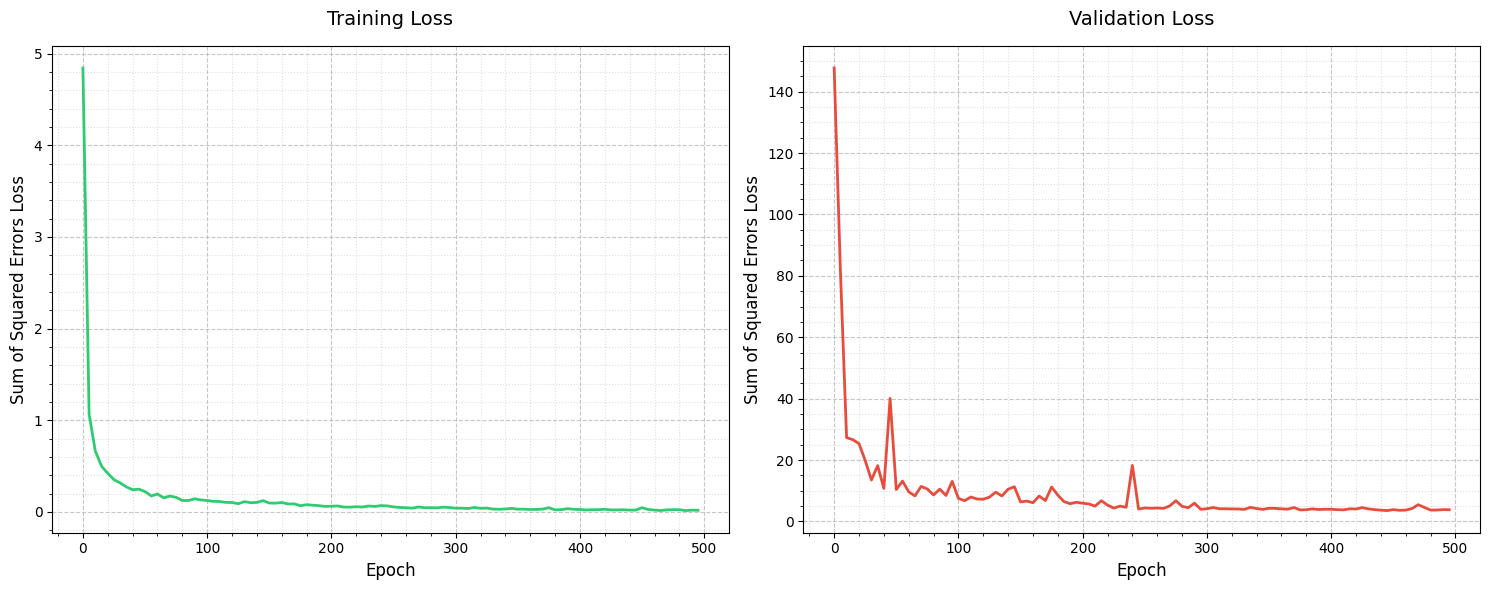

Training time of Network A: 33.175029039382935: s
Model saved to trained_weights_network_a.csv


In [22]:
input_size = X_train.shape[1]
output_size = y_train.shape[1]
network_a_activations=[Tanh(a=1.716, b=2/3), 
             Tanh(a=1.716, b=2/3), 
             Logistic(a=2.0)]

network_a = MLP(
                learning_rate=1e-3,
                input_size=input_size,
                output_size=output_size,
                hidden_sizes=[32, 32],
                activations=network_a_activations
            )

# Train Network A and get the training time
start_time = time.time()
network_a.train(X_train, y_train, X_val, y_val, n_epochs=500)
print(f"Training time of Network A: {time.time() - start_time}: s")

# Save the trained weights of Network A
network_a.save_model(NETWORK_A_WEIGHTS)

### Reconstruct Network A by loading its trained weights

In [23]:
loaded_network_a = MLP(
                learning_rate=1e-3,
                input_size=input_size,
                output_size=output_size,
                hidden_sizes=[32, 32],
                activations=network_a_activations
            )
loaded_network_a.load_model(NETWORK_A_WEIGHTS)

# Sanity Check: Confirm that the loaded network is correct
print(network_a.forward(X_val) == loaded_network_a.forward(X_val))

# Perform inference on the validation set for metrics
y_val_pred_network_a = loaded_network_a.forward(X_val)

layer_starts = [4, 360, 394]
Successfully loaded model state
Model loaded from trained_weights_network_a.csv
[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


### Classification metrics of Network A

In [24]:
print_classification_metrics(y_val, y_val_pred_network_a)


Classification Metrics:
------------------------------------------------------------
Overall Accuracy: 0.9938
Matthews Correlation Coefficient: 909.1162

Per-class metrics:
------------------------------------------------------------
Class     Precision     Recall   F1-Score
------------------------------------------------------------
1            1.0000     0.9717     0.9856
2            0.9886     1.0000     0.9943
3            1.0000     1.0000     1.0000
4            1.0000     1.0000     1.0000
5            1.0000     1.0000     1.0000
6            0.9898     0.9898     0.9898
7            1.0000     1.0000     1.0000
8            0.9700     0.9898     0.9798
------------------------------------------------------------
Macro        0.9936     0.9939     0.9937
------------------------------------------------------------


(<Figure size 1000x800 with 2 Axes>,
 <Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted Label', ylabel='True Label'>)

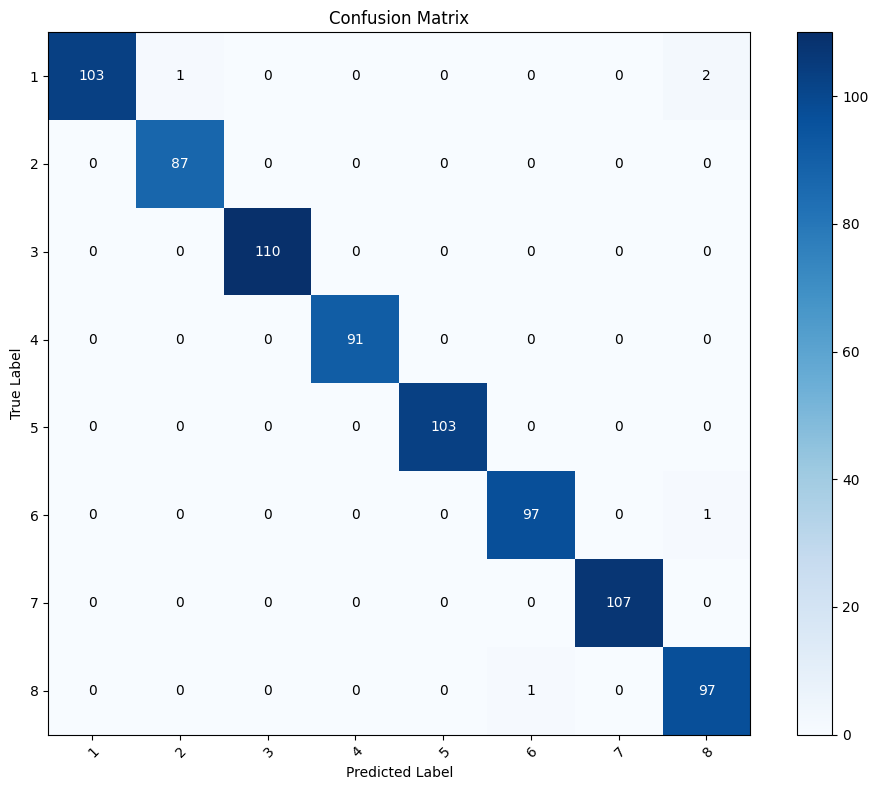

In [25]:
plot_confusion_matrix(y_val, y_val_pred_network_a)

### Perform inference on the test set and save predictions

In [26]:
y_test_pred_network_a = loaded_network_a.forward(X_test)
save_predictions(y_test_pred_network_a, NETWORK_A_PREDICTIONS)

Predictions saved to predictions_for_test_tanh.csv
Total samples: 701


## Network B
- Hidden Layer 1
    - Activation Function: `LeakyReLU(a=0.01)`
- Hidden Layer 2
    - Activation Function: `LeakyReLU(a=0.01)`
- Output Layer
    - Activation Function: `Logistic(a=2.0)`

Training the multilayer perceptron:   0%|          | 0/500 [00:00<?, ?it/s]

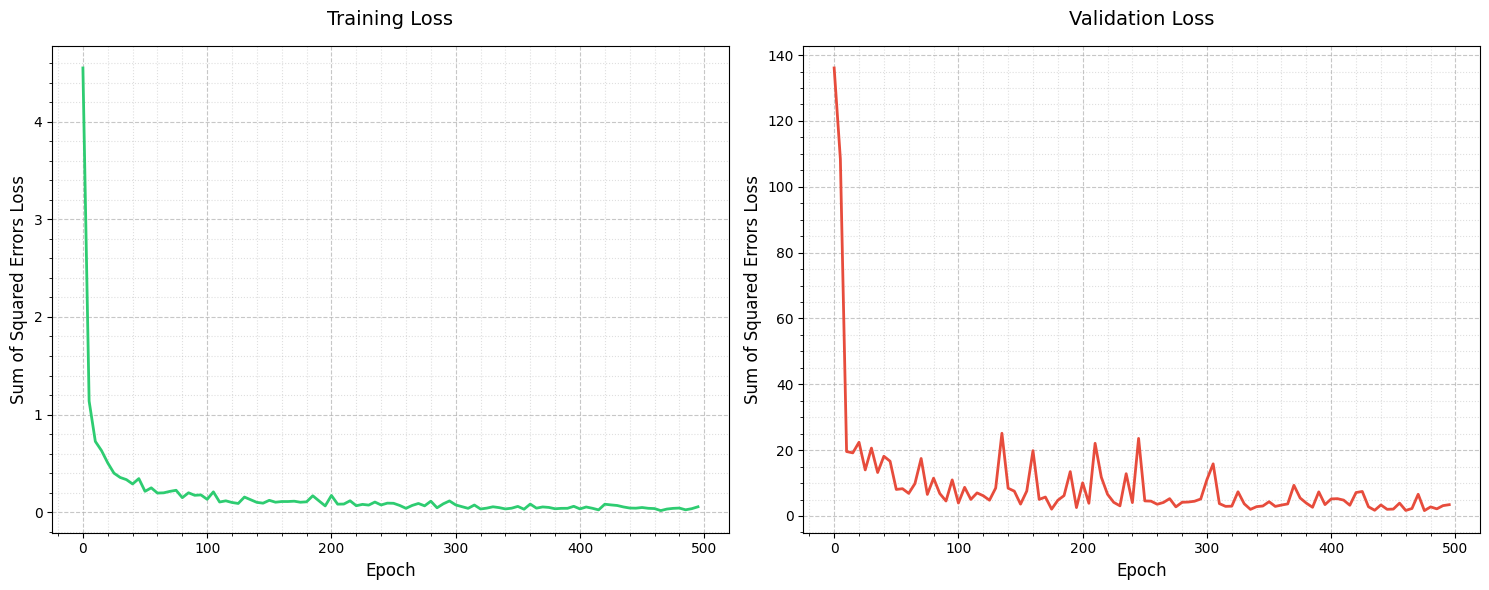

Training time of Network B: 31.884260177612305 s
Model saved to trained_weights_network_b.csv


In [27]:
input_size = X_train.shape[1]
output_size = y_train.shape[1]
network_b_activations=[LeakyReLU(a=0.01), 
                       LeakyReLU(a=0.01), 
                       Logistic(a=2.0)]

network_b = MLP(
                learning_rate=5e-3,
                input_size=input_size,
                output_size=output_size,
                hidden_sizes=[32, 32],
                activations=network_b_activations
            )

# Train Network B and get the training time
start_time = time.time()
network_b.train(X_train, y_train, X_val, y_val, n_epochs=500)
print(f"Training time of Network B: {time.time() - start_time} s")

# Save the trained weights of Network B
network_b.save_model("trained_weights_network_b.csv")

### Reconstruct Network B by loading its trained weights

In [28]:
loaded_network_b = MLP(
                learning_rate=5e-3,
                input_size=input_size,
                output_size=output_size,
                hidden_sizes=[32, 32],
                activations=network_b_activations
            )
loaded_network_b.load_model(NETWORK_B_WEIGHTS)

# Sanity Check: Confirm that the loaded network is correct
print(network_b.forward(X_val) == loaded_network_b.forward(X_val))

# Perform inference on the validation set for metrics
y_val_pred_network_b = loaded_network_b.forward(X_val)

layer_starts = [4, 360, 394]
Successfully loaded model state
Model loaded from trained_weights_network_b.csv
[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


### Classification metrics of Network B

In [29]:
print_classification_metrics(y_val, y_val_pred_network_b)


Classification Metrics:
------------------------------------------------------------
Overall Accuracy: 0.9950
Matthews Correlation Coefficient: 910.2648

Per-class metrics:
------------------------------------------------------------
Class     Precision     Recall   F1-Score
------------------------------------------------------------
1            1.0000     0.9811     0.9905
2            0.9886     1.0000     0.9943
3            1.0000     1.0000     1.0000
4            0.9785     1.0000     0.9891
5            1.0000     1.0000     1.0000
6            1.0000     1.0000     1.0000
7            0.9907     1.0000     0.9953
8            1.0000     0.9796     0.9897
------------------------------------------------------------
Macro        0.9947     0.9951     0.9949
------------------------------------------------------------


(<Figure size 1000x800 with 2 Axes>,
 <Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted Label', ylabel='True Label'>)

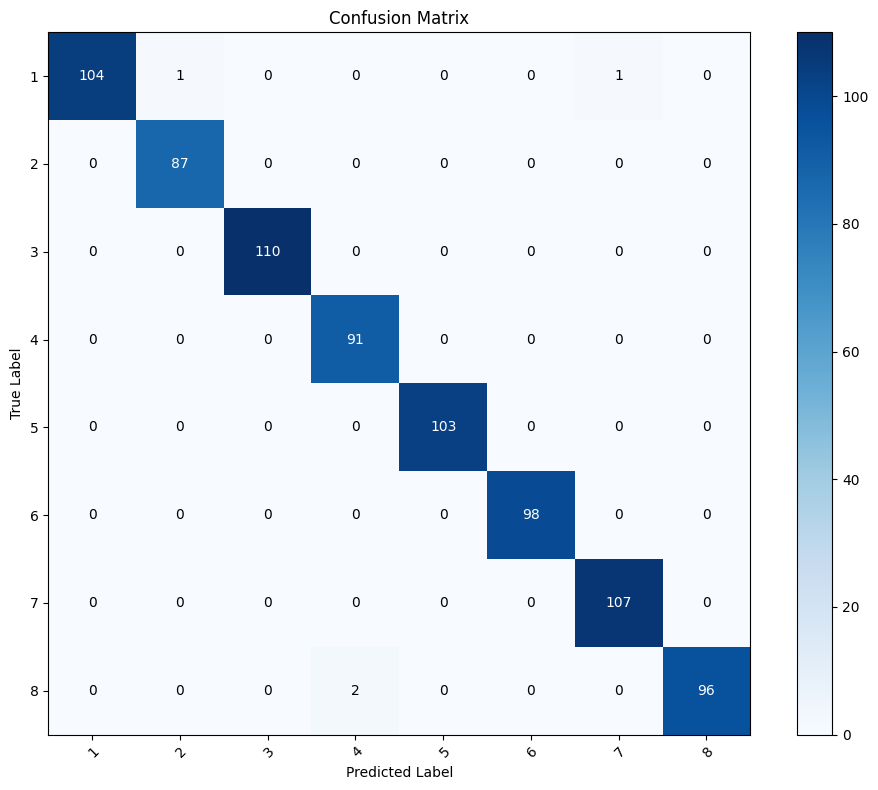

In [30]:
plot_confusion_matrix(y_val, y_val_pred_network_b)

### Perform inference on the test set and save predictions

In [31]:
y_test_pred_network_b = loaded_network_b.forward(X_test)
save_predictions(y_test_pred_network_b, NETWORK_B_PREDICTIONS)

Predictions saved to predictions_for_test_leakyrelu.csv
Total samples: 701
